In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
os.environ['HF_DATASETS_CACHE'] = '/nfs-data2/tungtx2/tmp/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/nfs-data2/tungtx2/tmp/huggingface'
os.environ['HF_HOME'] = '/nfs-data2/tungtx2/tmp/huggingface'

from pathlib import Path
import transformers

import torch
import torch.nn.functional as F
import pdb
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import ast

print(transformers.__version__)

4.44.2


In [6]:
current_dir = Path(os.getcwd())
print(current_dir)

/nfs-data2/tungtx2/Master/seminar2/SOSum_summarization/abstractive


# Split data (Run once)

In [7]:
from datasets import load_dataset

# Load the CSV file using load_dataset
ds = load_dataset('csv', data_files=os.path.join(current_dir.parent, 'data', 'answer.csv'))

# Inspect the dataset
print(ds)

Generating train split: 2278 examples [00:00, 58258.13 examples/s]

DatasetDict({
    train: Dataset({
        features: ['answer_body', 'truth', 'answer_id'],
        num_rows: 2278
    })
})


In [3]:
# Split the dataset into train and test
train_test_split = ds['train'].train_test_split(test_size=0.2, seed=42)

In [4]:
# Split the dataset into train and test
train_test_split = ds['train'].train_test_split(test_size=0.3, seed=42)

# Further split the test set into validation and test sets
test_val_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)

# Combine to form train, validation, and test sets
dataset_split = {
    'train': train_test_split['train'],
    'validation': test_val_split['train'],
    'test': test_val_split['test']
}

# Check the sizes of the splits
print(dataset_split)


{'train': Dataset({
    features: ['answer_body', 'truth', 'answer_id'],
    num_rows: 1594
}), 'validation': Dataset({
    features: ['answer_body', 'truth', 'answer_id'],
    num_rows: 342
}), 'test': Dataset({
    features: ['answer_body', 'truth', 'answer_id'],
    num_rows: 342
})}


In [5]:
import pandas as pd

# Convert to Pandas DataFrames and save as CSV
train_df = pd.DataFrame(dataset_split['train'])
validation_df = pd.DataFrame(dataset_split['validation'])
test_df = pd.DataFrame(dataset_split['test'])

# Save to CSV files
train_df.to_csv(os.path.join(current_dir.parent, 'data', 'train_dataset.csv'), index=False, encoding='utf-8')
validation_df.to_csv(os.path.join(current_dir.parent, 'data', 'validation_dataset.csv'), index=False, encoding='utf-8')
test_df.to_csv(os.path.join(current_dir.parent, 'data', 'test_dataset.csv'), index=False, encoding='utf-8')

print("Datasets saved to CSV!")

Datasets saved to CSV!


# Explore the data

In [8]:
from datasets import load_dataset

train_ds = load_dataset('csv', data_files=os.path.join(current_dir.parent, 'data', 'train_dataset.csv'))['train']
val_ds = load_dataset('csv', data_files=os.path.join(current_dir.parent, 'data', 'validation_dataset.csv'))['train']
test_ds = load_dataset('csv', data_files=os.path.join(current_dir.parent, 'data', 'test_dataset.csv'))['train']
print(train_ds)
print(val_ds)
print(test_ds)

Generating train split: 1594 examples [00:00, 77907.62 examples/s]
Generating train split: 342 examples [00:00, 40252.89 examples/s]
Generating train split: 342 examples [00:00, 33109.10 examples/s]

Dataset({
    features: ['answer_body', 'truth', 'answer_id'],
    num_rows: 1594
})
Dataset({
    features: ['answer_body', 'truth', 'answer_id'],
    num_rows: 342
})
Dataset({
    features: ['answer_body', 'truth', 'answer_id'],
    num_rows: 342
})


In [20]:
import pandas as pd

train_df = pd.DataFrame(train_ds)
train_df

,answer_body,truth,answer_id
0,['Note that Object.keys and other ECMAScript 5...,[0],3821585
1,"[""From Hacker's Delight, p. 66, Figure 5-2"", '...",[],109117
2,['You cannot display an application window/dia...,[0],2635366
3,['If your ultimate aim is to get debugging mes...,[0],4214596
4,"['To be clear about what is going on here:', '...","[1, 2, 4, 9]",1925501
...,...,...,...
1589,['In your Manifest file write this before <cod...,[0],4162699
1590,"['Consider following situation.', 'Suppose you...","[5, 7]",2472999
1591,"['You are reinventing the wheel.', 'Normal Pow...","[1,2]",2157625
1592,['My log4j got fixed by below property file:'],[0],1748695


In [26]:
# find special characters
from collections import Counter

def get_special_chars(df):
    special_chars = []
    for index, row in df.iterrows():
        list_sentences = ast.literal_eval(row['answer_body'])
        answer = ' '.join(list_sentences)
        special_chars.extend([c for c in answer if not (c.isalnum() or c in [' ', '.', ','])])
        # if '\x88' in answer:
        #     pdb.set_trace()
    return special_chars
    
chars = get_special_chars(train_df)
cnter = Counter(chars)
print(cnter)

Counter({'>': 6129, '<': 6037, '/': 4030, '_': 2299, "'": 2102, ')': 1945, ':': 1928, '(': 1890, '-': 1661, '"': 1142, ';': 575, '&': 375, '+': 325, '?': 299, '=': 189, '!': 118, '#': 114, '©': 88, '[': 82, ']': 81, '*': 80, '$': 73, '\x88': 62, '\\': 60, '%': 51, '@': 49, '¥': 47, '\x82': 46, '¦': 43, '^': 29, '¢': 27, '¨': 25, '{': 25, '}': 25, '|': 18, '~': 15, '\x8c': 15, '\x9a': 13, '´': 13, '\xa0': 10, '\x99': 9, '»': 6, '\x9b': 5, '·': 4, '\x94': 4, '\x89': 4, '§': 3, '\x9f': 3, '¸': 3, '\x8d': 3, '\x86': 2, '\x9e': 2, '\x87': 2, '\x85': 2, '\x96': 2, '\x97': 1, '\x93': 1, '\x91': 1, '\x92': 1, '\u200c': 1, '\u200b': 1, '¿': 1, '°': 1, '\x9d': 1, '\x8b': 1, '\x90': 1, '`': 1, '¯': 1})


In [24]:
cnter['\x88']

62

We can see there are many special characters like "\x86", "\x93",... Those are the control characters that are used to perform special function on the computer, not normal characters that represent some meanings. Maybe those characters are not presented in the vocabulary of the tokenizer so it will generate unknown token 

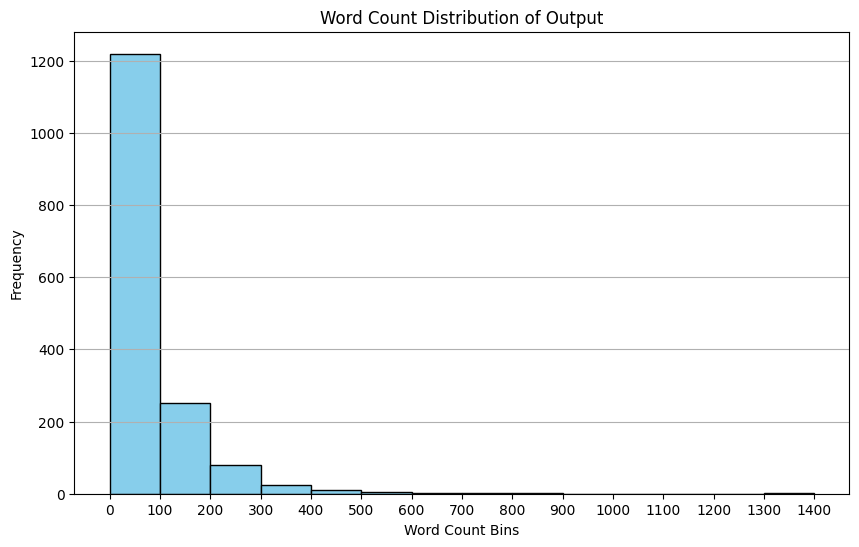

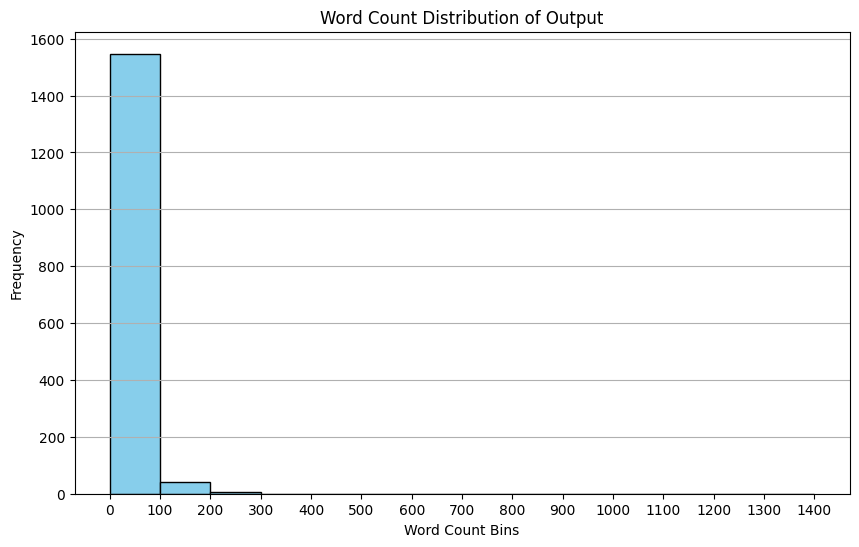

In [54]:
# get input length distribution
import matplotlib.pyplot as plt
import numpy as np

def get_words_length(df):
    num_input_words, num_output_words = [], []
    for index, row in df.iterrows():
        list_sentences = ast.literal_eval(row['answer_body'])
        answer = ' '.join(list_sentences)
        num_input_words.append(len(answer.split()))
        summary_indexes = ast.literal_eval(row['truth'])
        summary = ' '.join([list_sentences[index] for index in summary_indexes])
        num_output_words.append(len(summary.split()))
    return num_input_words, num_output_words


def plot_bin(input_list, bin_range):
    hist, edges = np.histogram(input_list, bins=bin_range)
    plt.figure(figsize=(10, 6))
    plt.bar(edges[:-1], hist, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black')
    plt.xlabel('Word Count Bins')
    plt.ylabel('Frequency')
    plt.title('Word Count Distribution of Output')
    plt.xticks(edges)  # Set x-ticks to the bin edges
    plt.grid(axis='y')
    plt.show()
    
num_input_words, num_output_words = get_words_length(train_df)
bins = np.arange(0, 1500, 100)  # Adjust the range and step as needed
plot_bin(num_input_words, bins)
plot_bin(num_output_words, bins)

In [23]:
print(max(num_input_words))
print(max(num_output_words))

1320
288


So most samples has input words less than 600 words and summary less then 300 words

Max input token length:  2782
Max output token length:  618
[919 391 130  76  37  10   9   6   7   3   1   1   2   0   0   0   1   0
   0   0   0   0   0   0   0   0   0]
[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700]


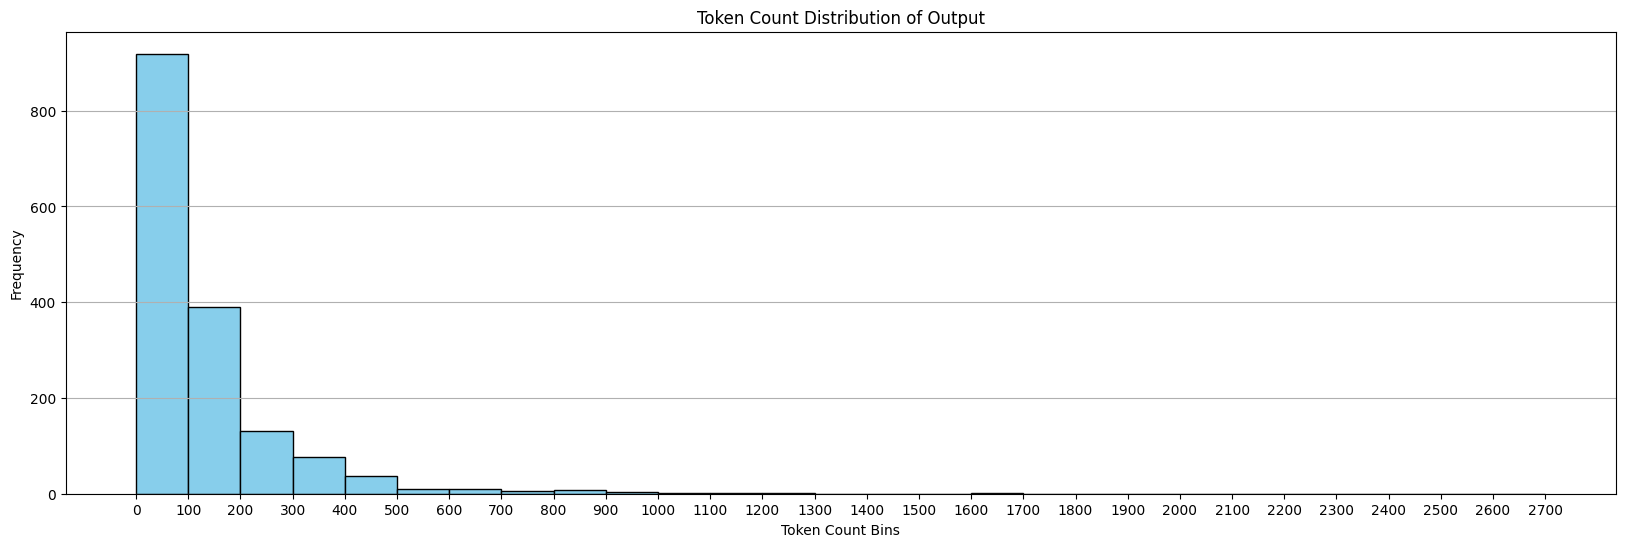

[1405  157   21    6    3    1    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700]


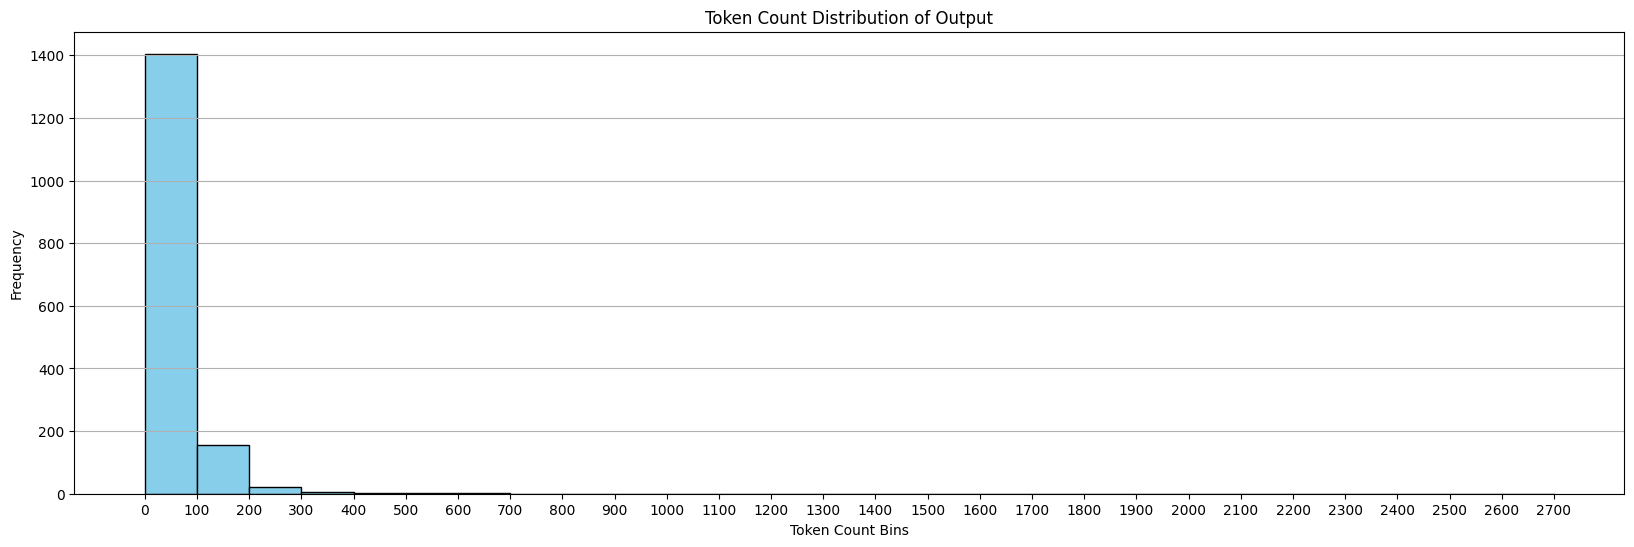

In [56]:
# get token length distribution
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-base')

def get_tokens_length(df):
    num_input_tokens, num_output_tokens = [], []
    for index, row in df.iterrows():
        list_sentences = ast.literal_eval(row['answer_body'])
        answer = ' '.join(list_sentences)
        text_tokens = tokenizer.tokenize(answer)
        num_input_tokens.append(len(text_tokens))

        summary_indexes = ast.literal_eval(row['truth'])
        summary = ' '.join([list_sentences[index] for index in summary_indexes])
        text_tokens = tokenizer.tokenize(summary)
        num_output_tokens.append(len(text_tokens))
        
    return num_input_tokens, num_output_tokens

def plot_bin(input_list, bin_range):
    hist, edges = np.histogram(input_list, bins=bin_range)
    print(hist)
    print(edges)
    plt.figure(figsize=(20, 6))
    plt.bar(edges[:-1], hist, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black')
    plt.xlabel('Token Count Bins')
    plt.ylabel('Frequency')
    plt.title('Token Count Distribution of Output')
    plt.xticks(edges)  # Set x-ticks to the bin edges
    plt.grid(axis='y')
    plt.show()
    
num_input_tokens, num_output_tokens = get_tokens_length(train_df)
print('Max input token length: ', max(num_input_tokens))
print('Max output token length: ', max(num_output_tokens))

bins = np.arange(0, 2800, 100)  # Adjust the range and step as needed
plot_bin(num_input_tokens, bins)
plot_bin(num_output_tokens, bins)

So most samples has input length < 1000 tokens and output length < 400

# Define Constant

In [9]:
# DATA
MODEL_CHECKPOINT = 'google-t5/t5-base'
MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 384
PREFIX = "summarize: "
BATCH_SIZE = 6

# TRAINER
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIMIT = 10
EPOCHS = 40
PREDICT_WITH_GENERATE = True
FP16 = True

# Preprocessing the data

In [32]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
print(tokenizer)

T5TokenizerFast(name_or_path='google-t5/t5-base', vocab_size=32100, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extr

In [33]:
def preprocess_function(examples):
    """
        for answer that has no summary (truth is an empty list) -> tokenizer will generate </s> token
    """
    # answer_body, truth, answer_id
    examples['answer'], examples['summary'] = [], []
    for list_sentences, truth in zip(examples['answer_body'], examples['truth']):
        list_sentences = ast.literal_eval(list_sentences)
        truth = ast.literal_eval(truth)
        examples['answer'].append(' '.join(list_sentences))
        summary = ' '.join([list_sentences[idx] for idx in truth])
        examples['summary'].append(summary)
    examples.pop('answer_body', None)
    examples.pop('truth', None)
    
    inputs = [PREFIX + doc for doc in examples["answer"]]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [34]:
train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)
test_ds = test_ds.map(preprocess_function, batched=True)

Map: 100%|██████████████████████████████████████████| 342/342 [00:00<00:00, 5617.17 examples/s]


In [61]:
val_ds[10]

{'answer_id': 1049759,
 'answer': 'For tables: <code>SHOW TABLE STATUS</code> will list all the tables. Filter using:',
 'summary': '<code>SHOW TABLE STATUS</code> will list all the tables.',
 'input_ids': [21603,
  10,
  242,
  5056,
  10,
  3,
  2,
  4978,
  3155,
  9122,
  15251,
  332,
  17098,
  5097,
  5767,
  3063,
  2,
  87,
  4978,
  3155,
  56,
  570,
  66,
  8,
  5056,
  5,
  6222,
  449,
  338,
  10,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [3,
  2,
  4978,
  3155,
  9122,
  15251,
  332,
  17098,
  5097,
  5767,
  3063,
  2,
  87,
  4978,
  3155,
  56,
  570,
  66,
  8,
  5056,
  5,
  1]}

In [63]:
tokenizer.decode(val_ds[10]['input_ids'])

'summarize: For tables: <unk>code>SHOW TABLE STATUS<unk>/code> will list all the tables. Filter using:</s>'

# Preprocess new json data

In [34]:
# # reformat data
# import json

# data = json.load(open('../data/SOSum/test.json'))
# for item_index, item in enumerate(data):
#     idx = item['instruction'].index('\n')
#     item['answer'] = item['instruction'][idx+2:]
#     item['summary'] = item['output']
# with open('../data/SOSum/test.json', 'w') as f:
#     json.dump(data, f, ensure_ascii=False)
# print('done')

done


In [3]:
from datasets import load_dataset

ds = load_dataset(
    "json",
    data_files={
        'train': os.path.join(current_dir.parent, 'data', 'train.json'),
        'val': os.path.join(current_dir.parent, 'data', 'val.json'),
    }
)
ds

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'answer', 'summary'],
        num_rows: 1466
    })
    val: Dataset({
        features: ['instruction', 'output', 'answer', 'summary'],
        num_rows: 316
    })
})

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
def preprocess_function(examples):
    """
        for answer that has no summary (truth is an empty list) -> tokenizer will generate </s> token
    """
    inputs = [PREFIX + doc for doc in examples["answer"]]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

ds = ds.map(preprocess_function, batched=True)
ds

/nfs-data2/tungtx2/new_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'answer', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1466
    })
    val: Dataset({
        features: ['instruction', 'output', 'answer', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 316
    })
})

In [5]:
train_ds = ds['train']
val_ds = ds['val']

# Finetune model

In [10]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [12]:
import nltk
import numpy as np
from evaluate import load

metric = load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    # Extract a few results
    result = {key: value * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [14]:
model_name = MODEL_CHECKPOINT.split("/")[-1]
training_args = Seq2SeqTrainingArguments(
    f"ckpt/{model_name}-finetuned-sosum/exp3_rouge_val",
    evaluation_strategy = "epoch",
    # eval_steps=150,
    save_strategy = "epoch",
    # save_steps = 150,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    save_total_limit=SAVE_TOTAL_LIMIT,
    num_train_epochs=EPOCHS,
    predict_with_generate=PREDICT_WITH_GENERATE,
    generation_max_length=MAX_TARGET_LENGTH,
    load_best_model_at_end=True,
    metric_for_best_model='rougeLsum',
    greater_is_better=True,
    fp16=FP16,
    push_to_hub=False,
)

In [15]:
trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/nfs-data2/tungtx2/new_env/lib/python3.10/site-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [16]:
trainer_stats = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: e97520a. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,0.104826,67.991600,63.261100,66.478600,67.086400,49.905100
2,No log,0.098545,68.996300,64.729400,67.595300,68.155500,62.060100
3,0.132700,0.102382,71.423600,67.596600,70.136600,70.689900,59.509500
4,0.132700,0.108215,70.670000,66.394000,69.069300,69.809300,58.120300
5,0.059300,0.126164,70.937000,67.100800,69.682000,70.277900,57.155100
6,0.059300,0.128847,73.105900,69.575300,71.872500,72.608000,61.737300
7,0.030800,0.130246,69.760800,65.666700,68.384700,68.928900,52.594900
8,0.030800,0.115482,69.796800,66.161600,68.722700,69.284900,51.636100
9,0.023000,0.118456,71.018000,67.038000,69.693600,70.393400,59.727800
10,0.023000,0.120659,70.325200,66.229400,68.964400,69.698400,59.955700


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [12]:
trainer_stats

TrainOutput(global_step=6125, training_loss=0.024345220663109603, metrics={'train_runtime': 973.5605, 'train_samples_per_second': 37.645, 'train_steps_per_second': 6.291, 'total_flos': 1.56146912792064e+16, 'train_loss': 0.024345220663109603, 'epoch': 25.0})

In [60]:
trainer.evaluate(eval_dataset=val_ds)

{'eval_loss': 0.15943433344364166,
 'eval_runtime': 1.8752,
 'eval_samples_per_second': 168.516,
 'eval_steps_per_second': 42.129,
 'epoch': 50.0}

In [50]:
best_model = trainer.model
best_model.eval()
print(best_model.device)

cuda:0


In [54]:
item = val_ds[22]
decoded_inp = tokenizer.decode(item['input_ids'])
decoded_out = tokenizer.decode(item['labels'])
print('Decoded input: ', decoded_inp)
print('Decoded output: ', decoded_out)

Decoded input:  summarize: This generally means that the owning Hibernate session has already closed. You can do one of the following to fix it: whichever object creating this problem, use <unk>code>HibernateTemplate.initialize(object name)<unk>/code> Use <unk>code>lazy=false<unk>/code> in your hbm files.</s>
Decoded output:  This generally means that the owning Hibernate session has already closed. You can do one of the following to fix it:</s>


In [55]:
input_ids = torch.tensor(item['input_ids']).to(best_model.device).unsqueeze(0)
attention_mask = torch.tensor(item['attention_mask']).to(best_model.device).unsqueeze(0)
labels = torch.tensor(item['labels']).to(best_model.device).unsqueeze(0)
print('Input ids shape: ', input_ids.shape)
print('attn mask shape: ', attention_mask.shape)

with torch.no_grad():
    generated_ids = best_model.generate(
        input_ids = input_ids,
        attention_mask = attention_mask, 
        max_length=256, 
        num_beams=2,
        repetition_penalty=2.5, 
        length_penalty=1.0, 
        early_stopping=True
    )
preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in labels]
print('Pred: ', preds)
print('Target: ', target)

Input ids shape:  torch.Size([1, 84])
attn mask shape:  torch.Size([1, 84])
Pred:  ['You can do one of the following to fix it: whichever object creating this problem, use code>HibernateTemplate.initialize(object name)/code>']
Target:  ['This generally means that the owning Hibernate session has already closed. You can do one of the following to fix it:']


In [30]:
trainer.state

TrainerState(epoch=25.0, global_step=6125, max_steps=6125, logging_steps=500, eval_steps=150, save_steps=150, train_batch_size=6, num_train_epochs=25, num_input_tokens_seen=0, total_flos=1.56146912792064e+16, log_history=[{'eval_loss': 0.10259958356618881, 'eval_runtime': 1.3198, 'eval_samples_per_second': 239.435, 'eval_steps_per_second': 40.158, 'epoch': 0.6122448979591837, 'step': 150}, {'eval_loss': 0.10352090001106262, 'eval_runtime': 1.3891, 'eval_samples_per_second': 227.484, 'eval_steps_per_second': 38.154, 'epoch': 1.2244897959183674, 'step': 300}, {'eval_loss': 0.10679997503757477, 'eval_runtime': 1.4397, 'eval_samples_per_second': 219.489, 'eval_steps_per_second': 36.813, 'epoch': 1.836734693877551, 'step': 450}, {'loss': 0.1342, 'grad_norm': 0.3223485052585602, 'learning_rate': 0.00018367346938775512, 'epoch': 2.0408163265306123, 'step': 500}, {'eval_loss': 0.11319718509912491, 'eval_runtime': 1.4521, 'eval_samples_per_second': 217.612, 'eval_steps_per_second': 36.498, 'epo

# Inference and Evaluate

In [57]:
# load model and tokenizer
device = 'cuda'

# ckpt_path = 'ckpt/t5-base-finetuned-sosum/exp2_save_more_ckpt/checkpoint-6000'
# tokenizer = AutoTokenizer.from_pretrained(ckpt_path)
# model = AutoModelForSeq2SeqLM.from_pretrained(ckpt_path)
# model.to(device).eval()

model = trainer.model
model.eval().to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [58]:
# load data
from datasets import load_dataset

ds = load_dataset(
    "json",
    data_files={
        'train': os.path.join(current_dir.parent, 'data', 'train.json'),
        'val': os.path.join(current_dir.parent, 'data', 'val.json'),
        'test': os.path.join(current_dir.parent, 'data', 'test.json')'
    }
)

MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 384
PREFIX = "summarize: "
BATCH_SIZE = 4

def preprocess_function(examples):
    """
        for answer that has no summary (truth is an empty list) -> tokenizer will generate </s> token
    """
    inputs = [PREFIX + doc for doc in examples["answer"]]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return {**examples, **model_inputs}

ds = ds.map(preprocess_function, batched=True)
ds

Map: 100%|███████████████████████████████████████| 310/310 [00:00<00:00, 3809.67 examples/s]


DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'answer', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1466
    })
    val: Dataset({
        features: ['instruction', 'output', 'answer', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 316
    })
    test: Dataset({
        features: ['instruction', 'output', 'answer', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 310
    })
})

In [33]:
import json

save_path = 'ckpt/t5-base-finetuned-sosum/exp3_rouge_val/model_output/best_checkpoint-test_pred.json'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

results = []
total = len(ds['test'])
for i, item in enumerate(ds['test']):
    input_ids = torch.tensor(item['input_ids']).to(device).unsqueeze(0)
    attention_mask = torch.tensor(item['attention_mask']).to(device).unsqueeze(0)
    labels = torch.tensor(item['labels']).to(device).unsqueeze(0)
    
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids = input_ids,
            attention_mask = attention_mask, 
            max_length=256, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
    pred = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids][0]
    target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in labels][0]
    results.append({
        'answer': item['answer'],
        'summary': item['summary'],
        'pred': pred
    })
    print('Pred: ', pred)
    print('Ground Truth: ', item['summary'])
    print(f'done item {i}/{total}\n')
    # if i == 3:
    #     break

with open(save_path, 'w') as f:
    json.dump(results, f, ensure_ascii=False)
print(f'Done save results !')

Pred:  As detailed in the comments, this code>Object[]/code> is now masquerading as our code>E[]/code> type, and can cause unexpected errors or code>ClassCastException/code>s if used unsafely.
Ground Truth:  You can always do this: <em>However</em> this triggers a warning because it is potentially dangerous, and should be used with caution. Worth mentioning that wherever possible, you'll have a much happier time working with <code>List</code>s rather than arrays if you're using generics.
done item 0/310

Pred:  However it doesn't have a print/save img as function.
Ground Truth:  Did you try <code>gitk</code> or <code>gitk --all</code> ?
done item 1/310

Pred:  Use the code>collate/code> clause in your query:
Ground Truth:  Use the <code>collate</code> clause in your query: I may not have the syntax exactly right (check BOL), but you can do this to change the collation on-the-fly for the query - you may need to add the clause for each join.
done item 2/310

Pred:  Using CROSS APPLY to o

In [60]:
# load result and evaluate
import evaluate
import json

# metric
rouge_score = evaluate.load("rouge")

pred_data = json.load(open(save_path))
predictions, references = [], []
for item in pred_data:
    predictions.append(item['pred'])
    references.append(item['summary'])
    
scores = rouge_score.compute(predictions=predictions, references=references)
scores

{'rouge1': 0.691446813833196,
 'rouge2': 0.6497126478629278,
 'rougeL': 0.6769734563153568,
 'rougeLsum': 0.6783136164520721}